In [6]:
!pip install kaggle
!mkdir -p ~/.kaggle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [8]:
!kaggle datasets download -d ruhulaminsharif/eye-disease-image-dataset -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/ruhulaminsharif/eye-disease-image-dataset
License(s): Attribution 4.0 International (CC BY 4.0)


In [13]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Set the base path to the dataset
base_path = '/content/Original_Dataset/Original_Dataset'  # Update this path accordingly

# Step 2: List all image paths and their corresponding labels
classes, paths = [], []
for label in os.listdir(base_path):
    class_dir = os.path.join(base_path, label)
    if os.path.isdir(class_dir):
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                classes.append(label)
                paths.append(os.path.join(class_dir, fname))

# Step 3: Create a DataFrame
df = pd.DataFrame({'Class': classes, 'Path': paths})

# Step 4: Split the data into training, validation, and testing sets
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Class'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Class'], random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(valid_df)}")
print(f"Testing samples: {len(test_df)}")


Training samples: 3734
Validation samples: 800
Testing samples: 801


In [21]:
df

,Class,Path
0,Retinitis Pigmentosa,/content/Original_Dataset/Original_Dataset/Ret...
1,Retinitis Pigmentosa,/content/Original_Dataset/Original_Dataset/Ret...
2,Retinitis Pigmentosa,/content/Original_Dataset/Original_Dataset/Ret...
3,Retinitis Pigmentosa,/content/Original_Dataset/Original_Dataset/Ret...
4,Retinitis Pigmentosa,/content/Original_Dataset/Original_Dataset/Ret...
...,...,...
5330,Central Serous Chorioretinopathy-Color Fundus,/content/Original_Dataset/Original_Dataset/Cen...
5331,Central Serous Chorioretinopathy-Color Fundus,/content/Original_Dataset/Original_Dataset/Cen...
5332,Central Serous Chorioretinopathy-Color Fundus,/content/Original_Dataset/Original_Dataset/Cen...
5333,Central Serous Chorioretinopathy-Color Fundus,/content/Original_Dataset/Original_Dataset/Cen...


Found 3734 validated image filenames belonging to 10 classes.


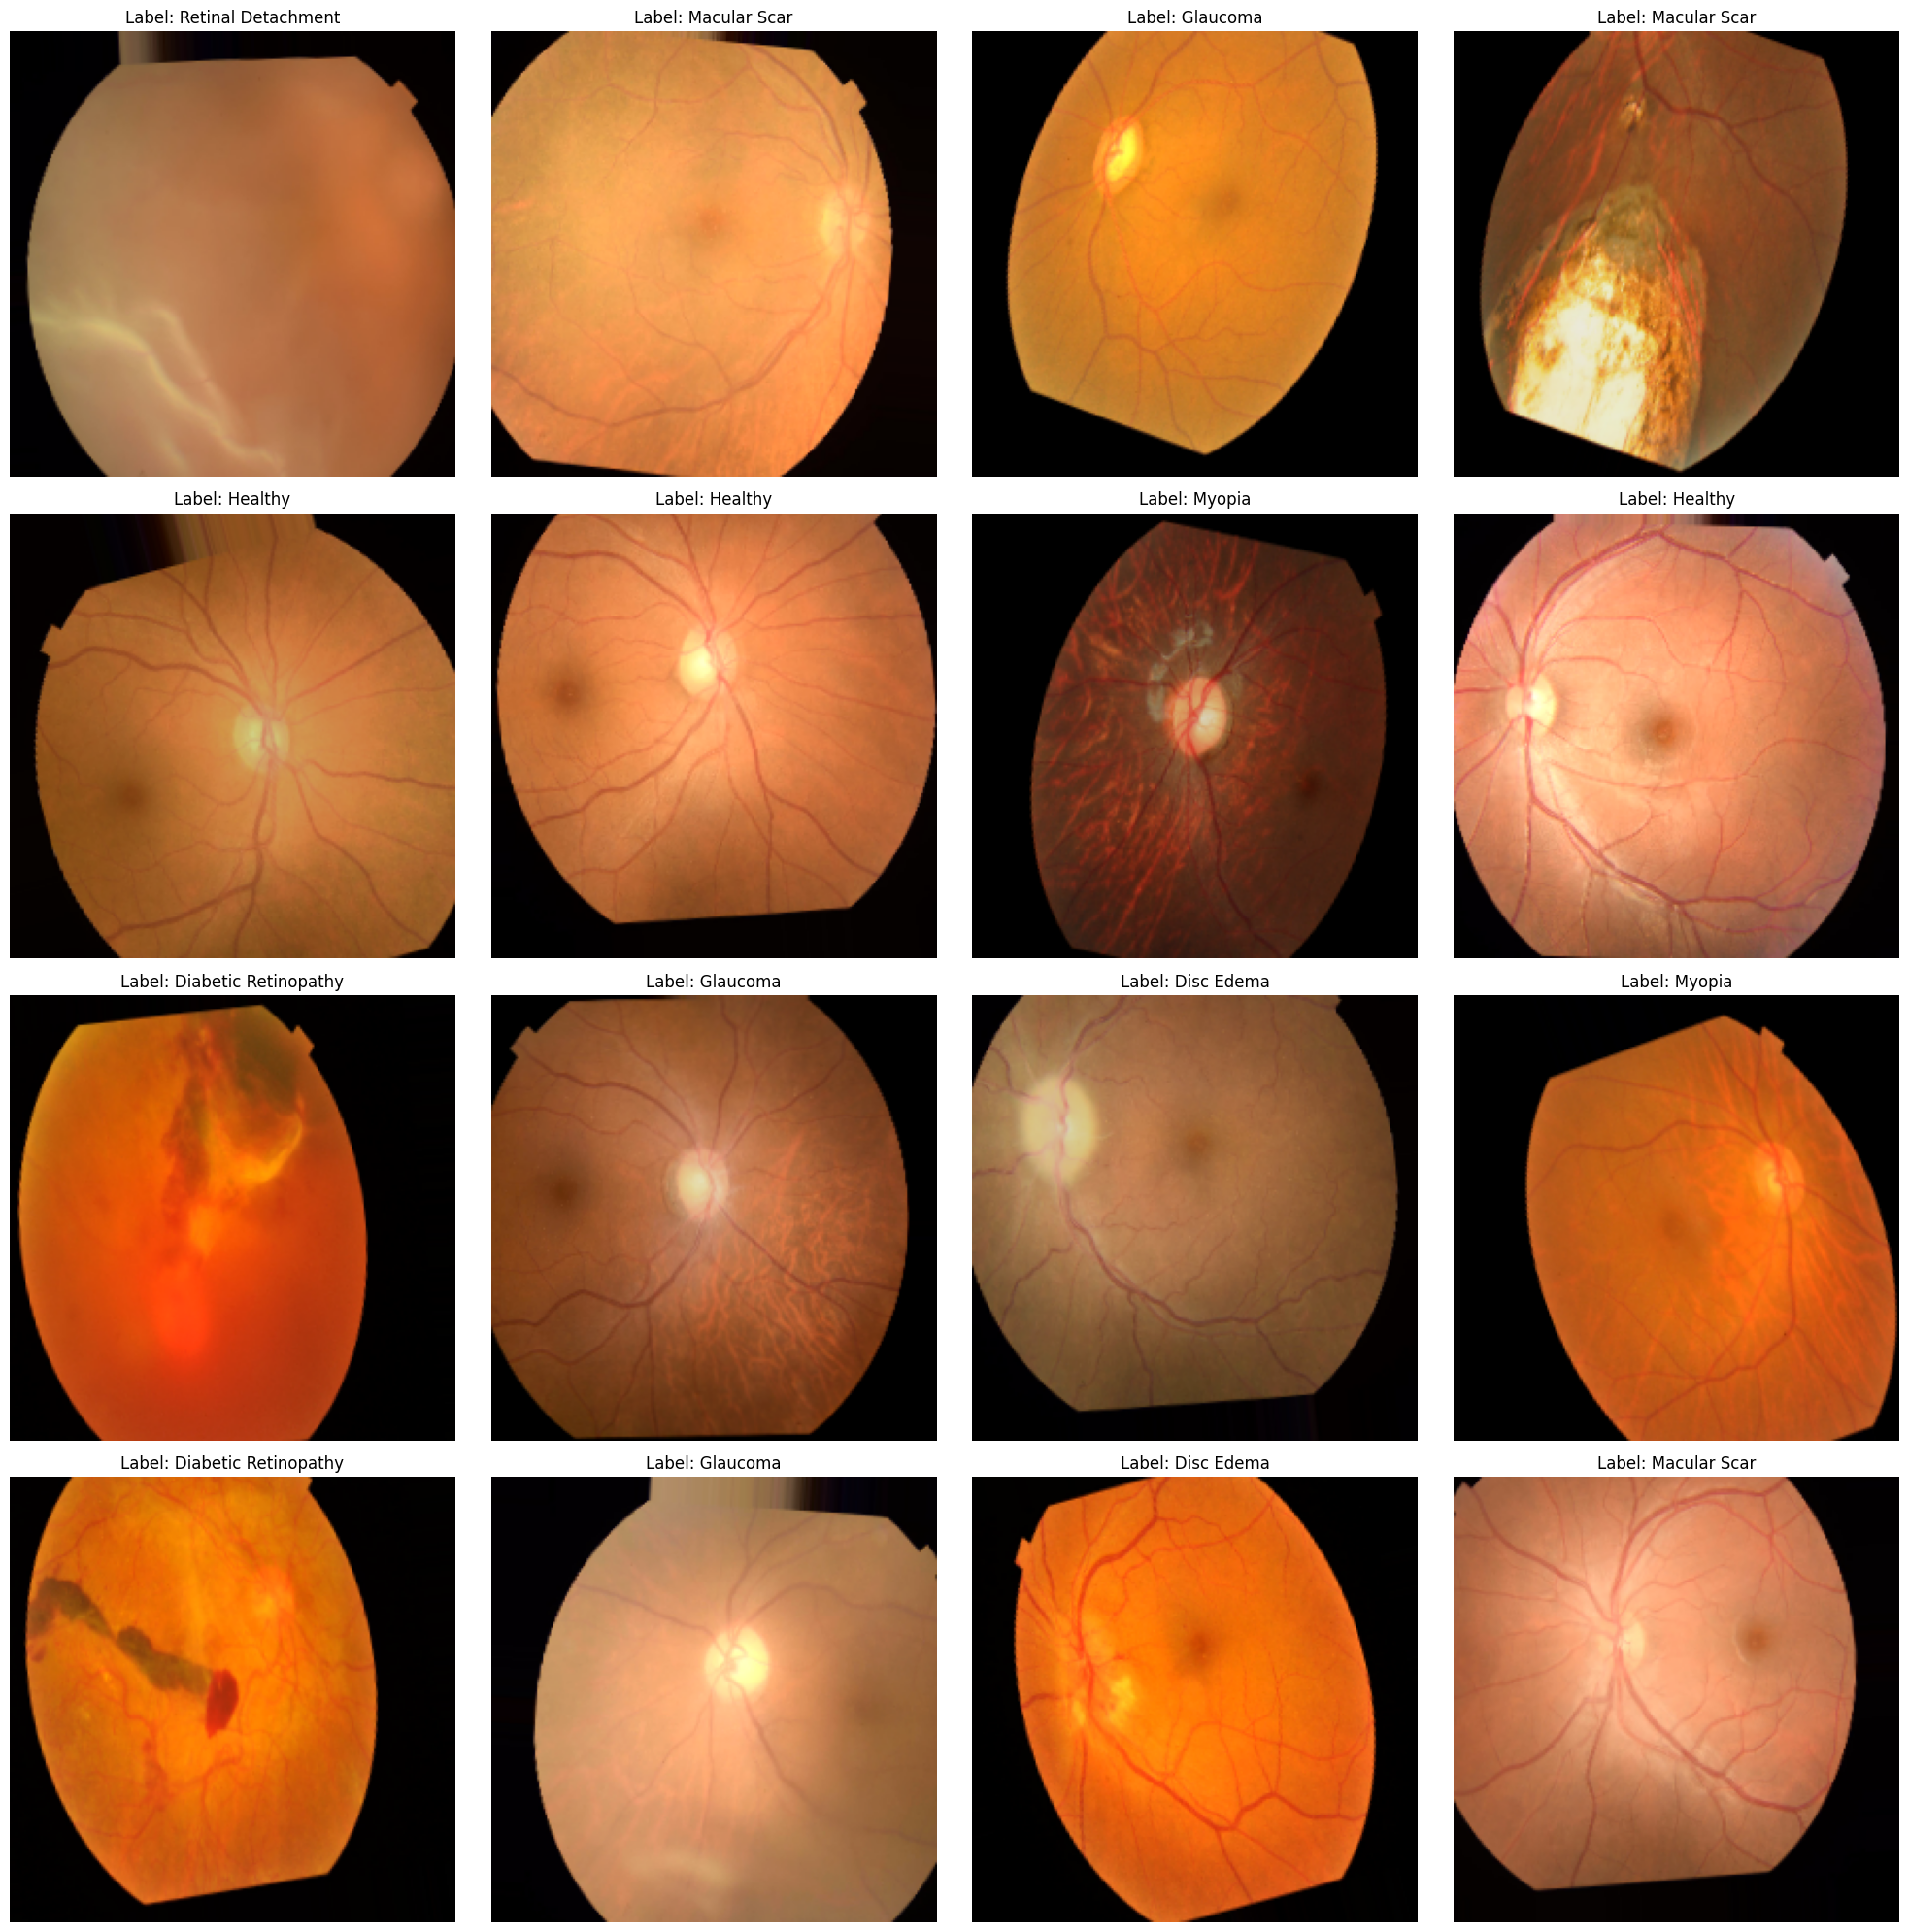

In [34]:
#first 16 img
tr_gen = make_generator(train_df, img_size=(224, 224), batch_size=32, augment=True)
import matplotlib.pyplot as plt
import numpy as np

# Fetch a batch of images and labels
batch = next(tr_gen)
images, labels = batch[0], batch[1]

# Get class names from the generator
class_names = list(tr_gen.class_indices.keys())

# Plot the images in a 4x4 grid
plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    class_index = np.argmax(labels[i])
    class_name = class_names[class_index]
    plt.title(f"Label: {class_name}")
    plt.axis('off')
plt.tight_layout()
plt.show()


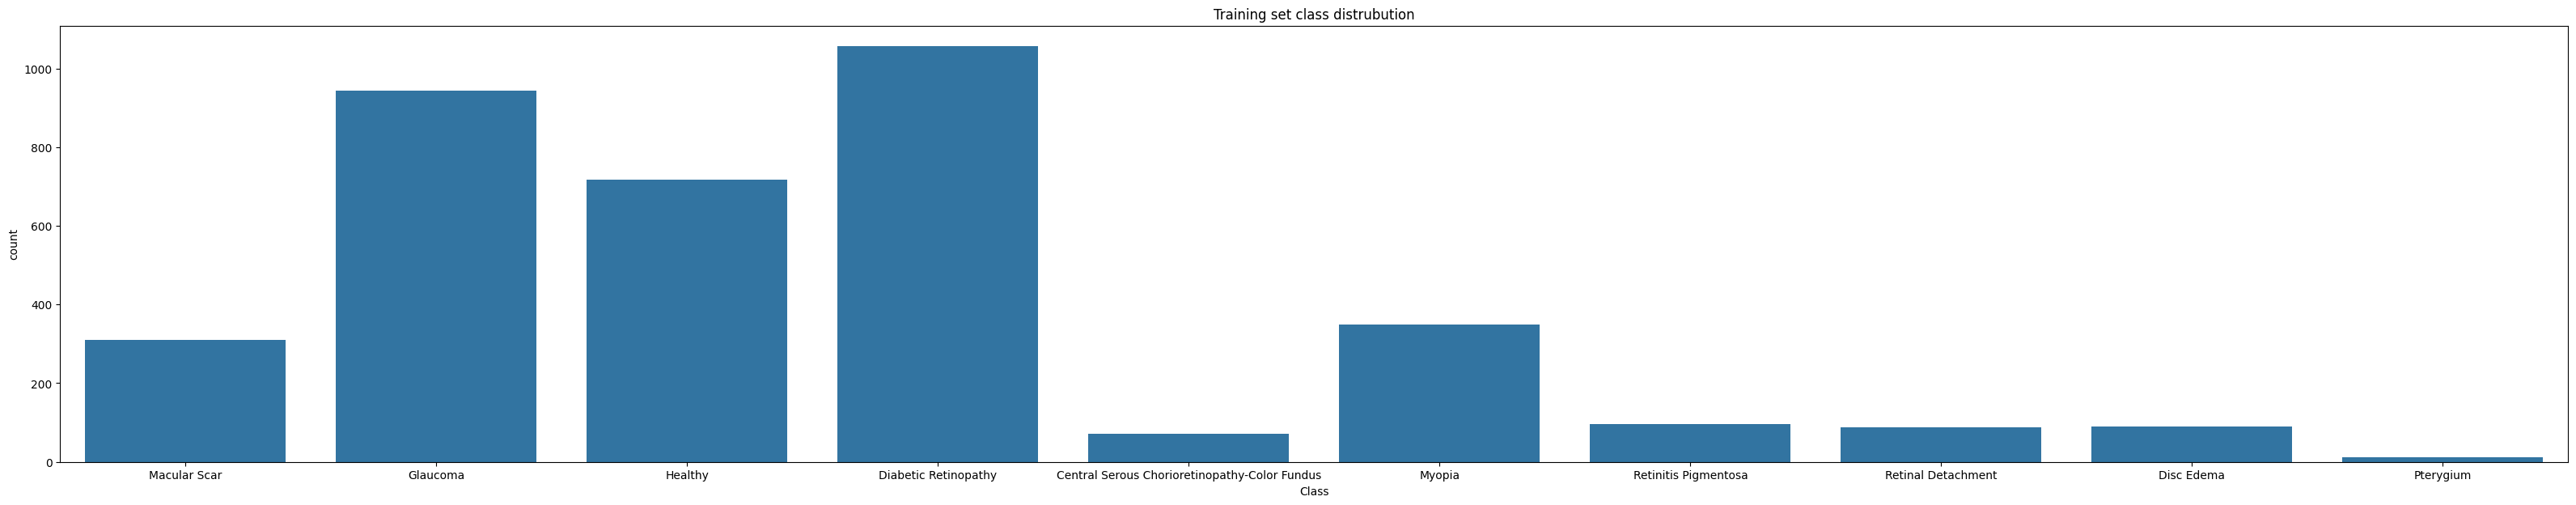

In [26]:
import seaborn as sns

plt.figure(figsize=(40,7))
plt.title('Training set class distrubution')
#sns.countplot() is a function that creates a bar
#chart showing the counts of different categories in a dataset.
#data=tr_df specifies that the data for the plot should be taken
# from the Pandas DataFrame called tr_df
#x=tr_df['Class'] tells the function to use the values in the 'Class' column of tr_df
# for the categories on the x-axis of the plot.
ax=sns.countplot(data=train_df,x=train_df['Class'])
#this dataset is pretty balanced

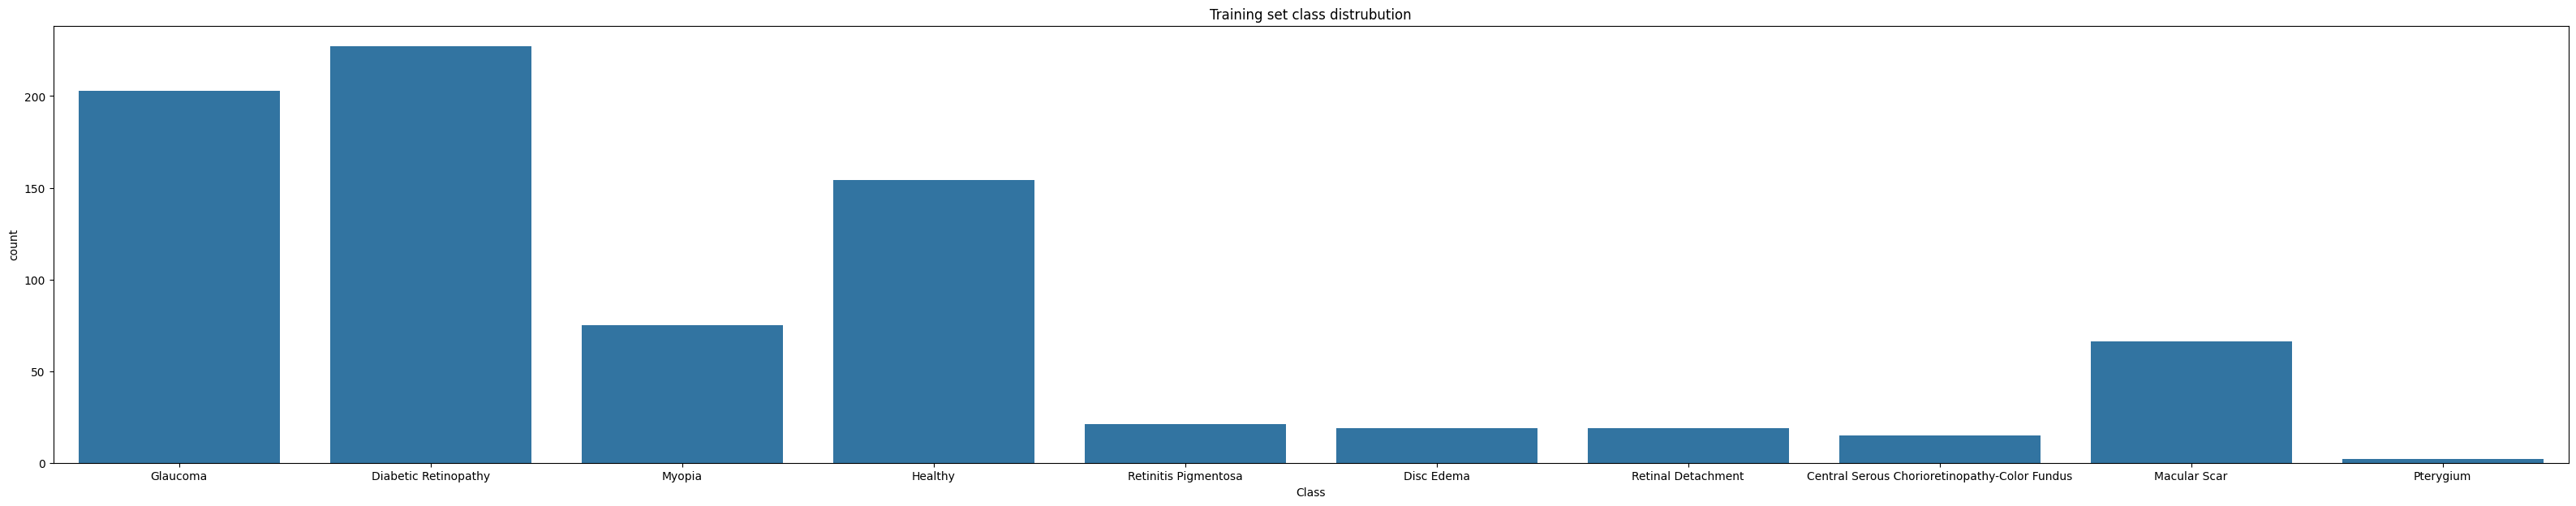

In [27]:
import seaborn as sns

plt.figure(figsize=(40,7))
plt.title('Training set class distrubution')
#sns.countplot() is a function that creates a bar
#chart showing the counts of different categories in a dataset.
#data=tr_df specifies that the data for the plot should be taken
# from the Pandas DataFrame called tr_df
#x=tr_df['Class'] tells the function to use the values in the 'Class' column of tr_df
# for the categories on the x-axis of the plot.
ax=sns.countplot(data=test_df,x=test_df['Class'])
#this dataset is pretty balanced

In [15]:
# 3. ImageDataGenerators
def make_generator(df, img_size, batch_size=32, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rescale=1/255,
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            brightness_range=(0.8,1.2),
            horizontal_flip=True
        )
    else:
        datagen = ImageDataGenerator(rescale=1/255)
    return datagen.flow_from_dataframe(
        df, x_col="Path", y_col="Class",
        target_size=img_size, batch_size=batch_size,
        class_mode="categorical", shuffle=augment
    )


In [16]:
from tensorflow.keras.applications import (
    VGG16, ResNet50, InceptionV3,
    vgg16, resnet50, inception_v3
)
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [17]:
def build_model(base_cls, input_shape, num_classes):
    base = base_cls(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=None
    )
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=base.input, outputs=outputs, name=base_cls.__name__)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [18]:
# Settings
NUM_CLASSES = train_df["Class"].nunique()
EPOCHS = 10
BATCH_SIZE = 32

# for each model input size
gens = {
    "VGG16": {
        "train": make_generator(train_df, img_size=(224,224), batch_size=BATCH_SIZE, augment=True),
        "valid": make_generator(valid_df, img_size=(224,224), batch_size=BATCH_SIZE, augment=False),
        "test" : make_generator(test_df,  img_size=(224,224), batch_size=BATCH_SIZE, augment=False)
    },
    "ResNet50": {
        "train": make_generator(train_df, img_size=(224,224), batch_size=BATCH_SIZE, augment=True),
        "valid": make_generator(valid_df, img_size=(224,224), batch_size=BATCH_SIZE, augment=False),
        "test" : make_generator(test_df,  img_size=(224,224), batch_size=BATCH_SIZE, augment=False)
    },
    "InceptionV3": {
        "train": make_generator(train_df, img_size=(299,299), batch_size=BATCH_SIZE, augment=True),
        "valid": make_generator(valid_df, img_size=(299,299), batch_size=BATCH_SIZE, augment=False),
        "test" : make_generator(test_df,  img_size=(299,299), batch_size=BATCH_SIZE, augment=False)
    },
}

# Build & train each model
histories = {}
for name, cls in [("VGG16", VGG16), ("ResNet50", ResNet50), ("InceptionV3", InceptionV3)]:
    print(f"\n=== Training {name} ===")
    model = build_model(cls, gens[name]["train"].image_shape, NUM_CLASSES)
    histories[name] = model.fit(
        gens[name]["train"],
        validation_data=gens[name]["valid"],
        epochs=EPOCHS
    )
    model.save(f"{name}_eye_disease.h5")


Found 3734 validated image filenames belonging to 10 classes.
Found 800 validated image filenames belonging to 10 classes.
Found 801 validated image filenames belonging to 10 classes.
Found 3734 validated image filenames belonging to 10 classes.
Found 800 validated image filenames belonging to 10 classes.
Found 801 validated image filenames belonging to 10 classes.
Found 3734 validated image filenames belonging to 10 classes.
Found 800 validated image filenames belonging to 10 classes.
Found 801 validated image filenames belonging to 10 classes.

=== Training VGG16 ===
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.3497 - loss: 1.8344 - val_accuracy: 0.5512 - val_loss: 1.3372
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.5967 - loss: 1.2157 - val_accuracy: 0.6700 - val_loss: 0.9652
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.6439 - loss: 1.0749 - val_accuracy: 0.6913 - val_loss: 0.8971
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.6984 - loss: 0.8929 - val_accuracy: 0.6875 - val_loss: 0.8665
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.7129 - loss: 0.8311 - val_accuracy: 0.7138 - val_loss: 0.7878
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.7404 - loss: 0.7657 - val_accuracy: 0.7500 - val_loss: 0.7132
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.7552 - loss: 0.6846 - val_accuracy: 0.7538 - val_loss: 0.6955
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.7596 - loss: 0.6593 - val_accu


=== Training ResNet50 ===
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.5165 - loss: 1.4136 - val_accuracy: 0.0787 - val_loss: 2.6052
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.7437 - loss: 0.7268 - val_accuracy: 0.1912 - val_loss: 2.2465
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.7711 - loss: 0.6253 - val_accuracy: 0.1912 - val_loss: 2.1932
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.8051 - loss: 0.5279 - val_accuracy: 0.1937 - val_loss: 2.3298
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.8210 - loss: 0.4798 - val_accuracy: 0.2500 - val_loss: 1.9662
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.8162 - loss: 0.4742 - val_accuracy: 0.2700 - val_loss: 3.1301
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.8340 - loss: 0.4258 - val_accuracy: 0.5337 - val_loss: 1.9839
Epoch 8/10
117/117 


=== Training InceptionV3 ===
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.5385 - loss: 1.3665 - val_accuracy: 0.7050 - val_loss: 0.8624
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.7478 - loss: 0.7262 - val_accuracy: 0.7362 - val_loss: 0.7888
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.7691 - loss: 0.6139 - val_accuracy: 0.7912 - val_loss: 0.6027
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.8032 - loss: 0.5387 - val_accuracy: 0.7462 - val_loss: 0.6857
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.8264 - loss: 0.4631 - val_accuracy: 0.7700 - val_loss: 0.6401
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.8477 - loss: 0.4187 - val_accuracy: 0.7638 - val_loss: 0.6812
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.8595 - loss: 0.3767 - val_accuracy: 0.7613 - val_loss: 0.6459
Epoch 8/10
117/1

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

results = {}
for name in ["VGG16", "ResNet50", "InceptionV3"]:
    print(f"\n--- Evaluating {name} ---")
    model = load_model(f"{name}_eye_disease.h5")
    test_gen = gens[name]["test"]
    preds = model.predict(test_gen, verbose=1)
    y_true = test_gen.classes
    y_pred = np.argmax(preds, axis=1)

    # Metrics
    print(classification_report(
        y_true, y_pred, target_names=list(test_gen.class_indices.keys())
    ))
    cm = confusion_matrix(y_true, y_pred)
    results[name] = {
        "accuracy": np.mean(y_true == y_pred),
        "confusion_matrix": cm
    }



--- Evaluating VGG16 ---
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 643ms/step
                                               precision    recall  f1-score   support

Central Serous Chorioretinopathy-Color Fundus       1.00      0.07      0.12        15
                         Diabetic Retinopathy       0.89      0.94      0.91       227
                                   Disc Edema       0.94      0.79      0.86        19
                                     Glaucoma       0.79      0.64      0.71       203
                                      Healthy       0.69      0.90      0.78       154
                                 Macular Scar       0.63      0.64      0.63        66
                                       Myopia       0.63      0.67      0.65        75
                                    Pterygium       1.00      1.00      1.00         2
                           Retinal Detachment       1.00      0.68      0.81        19
                         Retinitis Pigmentosa       0.94     

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 623ms/step
                                               precision    recall  f1-score   support

Central Serous Chorioretinopathy-Color Fundus       0.82      0.60      0.69        15
                         Diabetic Retinopathy       0.90      0.94      0.92       227
                                   Disc Edema       0.92      0.63      0.75        19
                                     Glaucoma       0.70      0.72      0.71       203
                                      Healthy       0.66      0.79      0.72       154
                                 Macular Scar       0.62      0.58      0.60        66
                                       Myopia       0.71      0.43      0.53        75
                                    Pterygium       1.00      1.00      1.00         2
                           Retinal Detachment       0.95      1.00      0.97        19
                         Retinitis Pigmentosa       0.84      0.76      0.80        21


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 26s 792ms/step
                                               precision    recall  f1-score   support

Central Serous Chorioretinopathy-Color Fundus       0.67      0.53      0.59        15
                         Diabetic Retinopathy       0.89      0.94      0.91       227
                                   Disc Edema       0.80      0.84      0.82        19
                                     Glaucoma       0.70      0.64      0.67       203
                                      Healthy       0.67      0.84      0.75       154
                                 Macular Scar       0.70      0.56      0.62        66
                                       Myopia       0.65      0.53      0.58        75
                                    Pterygium       1.00      1.00      1.00         2
                           Retinal Detachment       0.86      0.95      0.90        19
                         Retinitis Pigmentosa       1.00      0.57      0.73        21


In [20]:
# Summarize test accuracies
for name, info in results.items():
    print(f"{name:10s} Test Accuracy: {info['accuracy']*100:.2f}%")


VGG16      Test Accuracy: 77.53%
ResNet50   Test Accuracy: 76.03%
InceptionV3 Test Accuracy: 75.66%


In [ ]:
# # Compare the performance of the different models. Which one performed the best, and why do you think that is the case?
# VGG16: 77.53%
# ResNet50: 76.03%
# InceptionV3: 75.66%​

# here VGG16 got the highest test accuracy among the three models
# VGG16  test accuracy was well suited for this particular dataset.Because​
# 1.VGG16's straightforward architecture may have allowed it to generalize better without overfitting for the dataset size
# 2.Its deep convolutional layers are adept at capturing hierarchical features which can be beneficial for medical image classification.​

# ResNet50 and InceptionV3 are more complex architectures designed to capture intricate patterns their complexity might have led to overfitting or challenges in generalization on this dataset
# VGG16 outperformed ResNet50 and InceptionV3 in terms of test accuracy. Its simpler architecture and effective feature extraction capabilities likely contributed to its superior performance on the dataset.